In [6]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import h5py
import os
import time
import pickle

import scanpy.api as sc
import sceb.data_loader as dl 
import sceb.scdd as sd

%matplotlib inline
%load_ext autoreload
%autoreload 2

from matplotlib import rcParams

params = {
   'axes.labelsize': 16,
   'font.size': 16,
   'legend.fontsize': 10,
   'xtick.labelsize': 13,
   'ytick.labelsize': 13,
   'text.usetex': False,
   'text.usetex': False,
   }
rcParams.update(params)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
output_folder = '/home/martin/single_cell_eb/figures/figure_tradeoff_curve'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

## Subsample parameters

## Nc=1306127, G=72, Nr=1263.70, Nr_bar=17.55


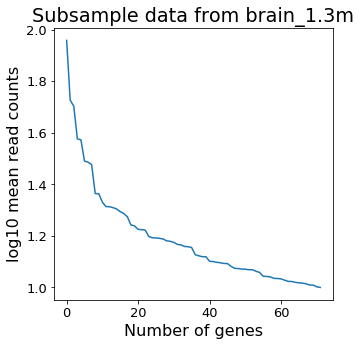

In [3]:
data_subsample = dl.load_10x_1_3mil_subsample()
Nc_subsample,G_subsample,Nr_subsample,Nr_bar_subsample = sd.get_info(data_subsample)
B_subsample = Nc_subsample*Nr_subsample

mean_count = np.array(data_subsample.X.mean(axis=0)).reshape(-1)
mean_count = np.sort(mean_count)[::-1]
plt.figure(figsize=[5,5])
plt.plot(np.arange(G_subsample),np.log10(mean_count))
plt.xlabel('Number of genes')
plt.ylabel('log10 mean read counts')
plt.title('Subsample data from brain_1.3m')
plt.savefig(output_folder+'/param_subsampled_data.png')
plt.savefig(output_folder+'/param_subsampled_data.pdf')
plt.show()

Nr_bar_list = [0.02,0.05,0.1,0.2,0.5,1,2,5,10]
B_sub_list = [int(B_subsample/37500), int(B_subsample/7500),int(B_subsample/1500),int(B_subsample/300)]
subsample_param_dic = {}
for B_sub in B_sub_list:    
    Nc_list = []
    for Nr_bar in Nr_bar_list:
        Nc_list.append(int(B_sub/Nr_bar/G_subsample))
        subsample_param_dic[B_sub] = [Nr_bar_list,Nc_list]
        
fname = output_folder+'/subsample_param.pickle'
f_myfile = open(fname,'wb')
pickle.dump(B_sub_list, f_myfile)
pickle.dump(subsample_param_dic, f_myfile)
f_myfile.close()

# Tradeoff curve

In [8]:
## Compute the ground truth
data_subsample = dl.load_10x_1_3mil_subsample()
Nc,G,Nr,Nr_bar = sd.get_info(data_subsample)

## CV estimation
M_ml_full,M_dd_full = sd.dd_1d_moment(data_subsample)
M_true = M_ml_full
cv_true = sd.M_to_cv(M_ml_full)
gamma_param_true = sd.M_to_gamma(M_true)

mean_ml_full,cov_ml_full,PeCo_ml_full = sd.ml_covariance(data_subsample)
cov_true = cov_ml_full
PeCo_true = PeCo_ml_full
_,V_true = np.linalg.eigh(cov_true)
p0_true,_ = sd.dd_zero_prob(data_subsample)

## Nc=1306127, G=72, Nr=1263.70, Nr_bar=17.55
#time start: 0.0s
n_cell=1306127, n_gene=72
#total: 2.83s
#time start: 0.0s
n_cell=1306127, n_gene=72, Nr=1263.7
#total: 27.97s
# time start: 0.0s
n_cell=1306127, n_gene=72
# total time: 8.5s


In [154]:
# ## diagnosis
# data = sc.read(subsample_folder+'/data_44014_0.05_3.60_12226_3.h5ad')
# Nr_=3.6

# M_ml,M_dd = sd.dd_1d_moment(data,verbose=False)

# gamma_param_ml = sd.M_to_gamma(M_ml)
# gamma_param_ml[0] *= Nr/Nr_
# gamma_param_dd = sd.M_to_gamma(M_dd)
# gamma_param_dd[0] *= Nr/Nr_
# err_ml = np.log10(np.mean((gamma_param_true[0]-gamma_param_ml[0])**2))\
#          - np.log10(np.mean(gamma_param_true[0]**2))
# err_dd = np.log10(np.mean((gamma_param_true[0]-gamma_param_dd[0])**2))\
#          - np.log10(np.mean(gamma_param_true[0]**2))
    
# err_ml = np.log10(np.mean((gamma_param_true[1]-gamma_param_ml[1])**2))\
#          - np.log10(np.mean(gamma_param_true[1]**2))
# err_dd = np.log10(np.mean((gamma_param_true[1]-gamma_param_dd[1])**2))\
#          - np.log10(np.mean(gamma_param_true[1]**2))

# print(err_ml)
# print(err_dd)

-0.02165372446034991
1.6542865294126137


In [9]:
start_time = time.time()

## on the original data
subsample_folder = '/data/martin/exp_sceb/subsample_1.3mil/subsampled_data_new'
filename_list = os.listdir(subsample_folder)

test_list = ['cv','gamma_theta','gamma_r','PC','PCA','zero']


## use a two-layer dic to store the result
err_ml_dic = {}
err_dd_dic = {}

for test_type in test_list:
    err_ml_dic[test_type] = {}
    err_dd_dic[test_type] = {}

## Initialization
for fname in filename_list:
#     if ('44014' not in fname):
#         continue  
    key_,_ = sd.fname_to_key(fname)
    for test_type in test_list:            
        err_ml_dic[test_type][key_] = []
        err_dd_dic[test_type][key_] = []
    
for fname in filename_list:
    key_,i_rep = sd.fname_to_key(fname)
    B_,Nr_bar_,Nr_,Nc_ = sd.key_to_param(key_)
    
    if '5501858' in fname:
        continue
        
    print(fname)
    
    data = sc.read(subsample_folder+'/'+fname)

    ## CV estimation
    M_ml,M_dd = sd.dd_1d_moment(data,verbose=False)
    
    cv_ml = sd.M_to_cv(M_ml)
    cv_dd = sd.M_to_cv(M_dd)
    err_ml = np.log10(np.mean((cv_true-cv_ml)**2)) - np.log10(np.mean(cv_true**2))
    err_dd = np.log10(np.mean((cv_true-cv_dd)**2)) - np.log10(np.mean(cv_true**2))
    err_ml_dic['cv'][key_].append(err_ml)
    err_dd_dic['cv'][key_].append(err_dd)
    
    gamma_param_ml = sd.M_to_gamma(M_ml)
    gamma_param_ml[0] *= Nr/Nr_
    gamma_param_dd = sd.M_to_gamma(M_dd)
    gamma_param_dd[0] *= Nr/Nr_
    err_ml = np.log10(np.mean((gamma_param_true[0]-gamma_param_ml[0])**2))\
             - np.log10(np.mean(gamma_param_true[0]**2))
    err_dd = np.log10(np.mean((gamma_param_true[0]-gamma_param_dd[0])**2))\
             - np.log10(np.mean(gamma_param_true[0]**2))
    err_ml_dic['gamma_theta'][key_].append(err_ml)
    err_dd_dic['gamma_theta'][key_].append(err_dd)
    err_ml = np.log10(np.mean((gamma_param_true[1]-gamma_param_ml[1])**2))\
             - np.log10(np.mean(gamma_param_true[1]**2))
    err_dd = np.log10(np.mean((gamma_param_true[1]-gamma_param_dd[1])**2))\
             - np.log10(np.mean(gamma_param_true[1]**2))
    err_ml_dic['gamma_r'][key_].append(err_ml)
    err_dd_dic['gamma_r'][key_].append(err_dd)
            
    ## Pearson correlation, PCA
    mean_ml,cov_ml,PeCo_ml = sd.ml_covariance(data,verbose=False)
    mean_dd,cov_dd,PeCo_dd = sd.dd_covariance(data,PC_prune=False,verbose=False)
    
    err_ml = np.log10(np.mean((PeCo_true-PeCo_ml)**2)) - np.log10(np.mean(PeCo_true**2))
    err_dd = np.log10(np.mean((PeCo_true-PeCo_dd)**2)) - np.log10(np.mean(PeCo_true**2))
    err_ml_dic['PC'][key_].append(err_ml)
    err_dd_dic['PC'][key_].append(err_dd)
    
    _,V_ml = np.linalg.eigh(cov_ml)
    _,V_dd = np.linalg.eigh(cov_dd)
    err_ml = np.log10(sd.cosine_distance(V_true[:,-1],V_ml[:,-1]))
    err_ml_dic['PCA'][key_].append(err_ml)
    err_dd = np.log10(sd.cosine_distance(V_true[:,-1],V_dd[:,-1]))
    err_dd_dic['PCA'][key_].append(err_dd)
    
    ## zero
    p0_ml,p0_dd = sd.dd_inactive_prob(data,relative_depth=Nr_/Nr,verbose=False)
    err_ml = np.log10(np.mean((p0_ml-p0_true)**2)) - np.log10(np.mean(p0_true**2))
    err_dd = np.log10(np.mean((p0_dd-p0_true)**2)) - np.log10(np.mean(p0_true**2))
    err_ml_dic['zero'][key_].append(err_ml)
    err_dd_dic['zero'][key_].append(err_dd)
        
## Save the data
fname = output_folder+'/tradeoff_data.pickle'
f_myfile = open(fname,'wb')
pickle.dump(err_ml_dic, f_myfile)
pickle.dump(err_dd_dic, f_myfile)
f_myfile.close()

print('total time: %0.1f'%(time.time()-start_time))

data_44014_0.02_1.44_30565_0.h5ad
data_44014_0.02_1.44_30565_1.h5ad
data_44014_0.02_1.44_30565_2.h5ad
data_44014_0.02_1.44_30565_3.h5ad
data_44014_0.02_1.44_30565_4.h5ad
data_44014_0.02_1.44_30565_5.h5ad
data_44014_0.02_1.44_30565_6.h5ad
data_44014_0.02_1.44_30565_7.h5ad
data_44014_0.02_1.44_30565_8.h5ad
data_44014_0.02_1.44_30565_9.h5ad
data_44014_0.02_1.44_30565_10.h5ad
data_44014_0.02_1.44_30565_11.h5ad
data_44014_0.02_1.44_30565_12.h5ad
data_44014_0.02_1.44_30565_13.h5ad
data_44014_0.02_1.44_30565_14.h5ad
data_44014_0.02_1.44_30565_15.h5ad
data_44014_0.02_1.44_30565_16.h5ad
data_44014_0.02_1.44_30565_17.h5ad
data_44014_0.02_1.44_30565_18.h5ad
data_44014_0.02_1.44_30565_19.h5ad
data_44014_0.02_1.44_30565_20.h5ad
data_44014_0.02_1.44_30565_21.h5ad
data_44014_0.02_1.44_30565_22.h5ad
data_44014_0.02_1.44_30565_23.h5ad
data_44014_0.02_1.44_30565_24.h5ad
data_44014_0.02_1.44_30565_25.h5ad
data_44014_0.02_1.44_30565_26.h5ad
data_44014_0.02_1.44_30565_27.h5ad
data_44014_0.02_1.44_30565_28.

data_44014_0.10_7.20_6113_37.h5ad
data_44014_0.10_7.20_6113_38.h5ad
data_44014_0.10_7.20_6113_39.h5ad
data_44014_0.10_7.20_6113_40.h5ad
data_44014_0.10_7.20_6113_41.h5ad
data_44014_0.10_7.20_6113_42.h5ad
data_44014_0.10_7.20_6113_43.h5ad
data_44014_0.10_7.20_6113_44.h5ad
data_44014_0.10_7.20_6113_45.h5ad
data_44014_0.10_7.20_6113_46.h5ad
data_44014_0.10_7.20_6113_47.h5ad
data_44014_0.10_7.20_6113_48.h5ad
data_44014_0.10_7.20_6113_49.h5ad
data_44014_0.10_7.20_6113_50.h5ad
data_44014_0.10_7.20_6113_51.h5ad
data_44014_0.10_7.20_6113_52.h5ad
data_44014_0.10_7.20_6113_53.h5ad
data_44014_0.10_7.20_6113_54.h5ad
data_44014_0.10_7.20_6113_55.h5ad
data_44014_0.10_7.20_6113_56.h5ad
data_44014_0.10_7.20_6113_57.h5ad
data_44014_0.10_7.20_6113_58.h5ad
data_44014_0.10_7.20_6113_59.h5ad
data_44014_0.10_7.20_6113_60.h5ad
data_44014_0.10_7.20_6113_61.h5ad
data_44014_0.10_7.20_6113_62.h5ad
data_44014_0.10_7.20_6113_63.h5ad
data_44014_0.10_7.20_6113_64.h5ad
data_44014_0.10_7.20_6113_65.h5ad
data_44014_0.1

data_44014_0.50_36.00_1222_75.h5ad
data_44014_0.50_36.00_1222_76.h5ad
data_44014_0.50_36.00_1222_77.h5ad
data_44014_0.50_36.00_1222_78.h5ad
data_44014_0.50_36.00_1222_79.h5ad
data_44014_0.50_36.00_1222_80.h5ad
data_44014_0.50_36.00_1222_81.h5ad
data_44014_0.50_36.00_1222_82.h5ad
data_44014_0.50_36.00_1222_83.h5ad
data_44014_0.50_36.00_1222_84.h5ad
data_44014_0.50_36.00_1222_85.h5ad
data_44014_0.50_36.00_1222_86.h5ad
data_44014_0.50_36.00_1222_87.h5ad
data_44014_0.50_36.00_1222_88.h5ad
data_44014_0.50_36.00_1222_89.h5ad
data_44014_0.50_36.00_1222_90.h5ad
data_44014_0.50_36.00_1222_91.h5ad
data_44014_0.50_36.00_1222_92.h5ad
data_44014_0.50_36.00_1222_93.h5ad
data_44014_0.50_36.00_1222_94.h5ad
data_44014_0.50_36.00_1222_95.h5ad
data_44014_0.50_36.00_1222_96.h5ad
data_44014_0.50_36.00_1222_97.h5ad
data_44014_0.50_36.00_1222_98.h5ad
data_44014_0.50_36.00_1222_99.h5ad
data_44014_1.00_72.00_611_0.h5ad
data_44014_1.00_72.00_611_1.h5ad
data_44014_1.00_72.00_611_2.h5ad
data_44014_1.00_72.00_611_

data_44014_5.00_360.00_122_17.h5ad
data_44014_5.00_360.00_122_18.h5ad
data_44014_5.00_360.00_122_19.h5ad
data_44014_5.00_360.00_122_20.h5ad
data_44014_5.00_360.00_122_21.h5ad
data_44014_5.00_360.00_122_22.h5ad
data_44014_5.00_360.00_122_23.h5ad
data_44014_5.00_360.00_122_24.h5ad
data_44014_5.00_360.00_122_25.h5ad
data_44014_5.00_360.00_122_26.h5ad
data_44014_5.00_360.00_122_27.h5ad
data_44014_5.00_360.00_122_28.h5ad
data_44014_5.00_360.00_122_29.h5ad
data_44014_5.00_360.00_122_30.h5ad
data_44014_5.00_360.00_122_31.h5ad
data_44014_5.00_360.00_122_32.h5ad
data_44014_5.00_360.00_122_33.h5ad
data_44014_5.00_360.00_122_34.h5ad
data_44014_5.00_360.00_122_35.h5ad
data_44014_5.00_360.00_122_36.h5ad
data_44014_5.00_360.00_122_37.h5ad
data_44014_5.00_360.00_122_38.h5ad
data_44014_5.00_360.00_122_39.h5ad
data_44014_5.00_360.00_122_40.h5ad
data_44014_5.00_360.00_122_41.h5ad
data_44014_5.00_360.00_122_42.h5ad
data_44014_5.00_360.00_122_43.h5ad
data_44014_5.00_360.00_122_44.h5ad
data_44014_5.00_360.

/home/martin/single_cell_eb/sceb/scdd.py:891: RuntimeWarning: divide by zero encountered in true_divide
  
/home/martin/single_cell_eb/sceb/scdd.py:919: RuntimeWarning: invalid value encountered in true_divide
  return gamma_param
/home/martin/single_cell_eb/sceb/scdd.py:920: RuntimeWarning: invalid value encountered in true_divide
  
/home/martin/single_cell_eb/sceb/scdd.py:307: RuntimeWarning: invalid value encountered in true_divide
  PC_ml = cov_ml/(std_ml.dot(std_ml.T))
/home/martin/single_cell_eb/sceb/scdd.py:244: RuntimeWarning: invalid value encountered in true_divide
  index_bad[(diag_cov_dd/mean_dd)<0.1] = True
/home/martin/single_cell_eb/sceb/scdd.py:244: RuntimeWarning: invalid value encountered in less
  index_bad[(diag_cov_dd/mean_dd)<0.1] = True


data_44014_10.00_720.00_61_94.h5ad
data_44014_10.00_720.00_61_95.h5ad
data_44014_10.00_720.00_61_96.h5ad
data_44014_10.00_720.00_61_97.h5ad
data_44014_10.00_720.00_61_98.h5ad
data_44014_10.00_720.00_61_99.h5ad
data_220074_0.02_1.44_152829_0.h5ad
data_220074_0.02_1.44_152829_1.h5ad
data_220074_0.02_1.44_152829_2.h5ad
data_220074_0.02_1.44_152829_3.h5ad
data_220074_0.02_1.44_152829_4.h5ad
data_220074_0.02_1.44_152829_5.h5ad
data_220074_0.02_1.44_152829_6.h5ad
data_220074_0.02_1.44_152829_7.h5ad
data_220074_0.02_1.44_152829_8.h5ad
data_220074_0.02_1.44_152829_9.h5ad
data_220074_0.02_1.44_152829_10.h5ad
data_220074_0.02_1.44_152829_11.h5ad
data_220074_0.02_1.44_152829_12.h5ad
data_220074_0.02_1.44_152829_13.h5ad
data_220074_0.02_1.44_152829_14.h5ad
data_220074_0.02_1.44_152829_15.h5ad
data_220074_0.02_1.44_152829_16.h5ad
data_220074_0.02_1.44_152829_17.h5ad
data_220074_0.02_1.44_152829_18.h5ad
data_220074_0.02_1.44_152829_19.h5ad
data_220074_0.02_1.44_152829_20.h5ad
data_220074_0.02_1.44_1

data_220074_0.10_7.20_30565_20.h5ad
data_220074_0.10_7.20_30565_21.h5ad
data_220074_0.10_7.20_30565_22.h5ad
data_220074_0.10_7.20_30565_23.h5ad
data_220074_0.10_7.20_30565_24.h5ad
data_220074_0.10_7.20_30565_25.h5ad
data_220074_0.10_7.20_30565_26.h5ad
data_220074_0.10_7.20_30565_27.h5ad
data_220074_0.10_7.20_30565_28.h5ad
data_220074_0.10_7.20_30565_29.h5ad
data_220074_0.10_7.20_30565_30.h5ad
data_220074_0.10_7.20_30565_31.h5ad
data_220074_0.10_7.20_30565_32.h5ad
data_220074_0.10_7.20_30565_33.h5ad
data_220074_0.10_7.20_30565_34.h5ad
data_220074_0.10_7.20_30565_35.h5ad
data_220074_0.10_7.20_30565_36.h5ad
data_220074_0.10_7.20_30565_37.h5ad
data_220074_0.10_7.20_30565_38.h5ad
data_220074_0.10_7.20_30565_39.h5ad
data_220074_0.10_7.20_30565_40.h5ad
data_220074_0.10_7.20_30565_41.h5ad
data_220074_0.10_7.20_30565_42.h5ad
data_220074_0.10_7.20_30565_43.h5ad
data_220074_0.10_7.20_30565_44.h5ad
data_220074_0.10_7.20_30565_45.h5ad
data_220074_0.10_7.20_30565_46.h5ad
data_220074_0.10_7.20_30565_

data_220074_0.50_36.00_6113_46.h5ad
data_220074_0.50_36.00_6113_47.h5ad
data_220074_0.50_36.00_6113_48.h5ad
data_220074_0.50_36.00_6113_49.h5ad
data_220074_0.50_36.00_6113_50.h5ad
data_220074_0.50_36.00_6113_51.h5ad
data_220074_0.50_36.00_6113_52.h5ad
data_220074_0.50_36.00_6113_53.h5ad
data_220074_0.50_36.00_6113_54.h5ad
data_220074_0.50_36.00_6113_55.h5ad
data_220074_0.50_36.00_6113_56.h5ad
data_220074_0.50_36.00_6113_57.h5ad
data_220074_0.50_36.00_6113_58.h5ad
data_220074_0.50_36.00_6113_59.h5ad
data_220074_0.50_36.00_6113_60.h5ad
data_220074_0.50_36.00_6113_61.h5ad
data_220074_0.50_36.00_6113_62.h5ad
data_220074_0.50_36.00_6113_63.h5ad
data_220074_0.50_36.00_6113_64.h5ad
data_220074_0.50_36.00_6113_65.h5ad
data_220074_0.50_36.00_6113_66.h5ad
data_220074_0.50_36.00_6113_67.h5ad
data_220074_0.50_36.00_6113_68.h5ad
data_220074_0.50_36.00_6113_69.h5ad
data_220074_0.50_36.00_6113_70.h5ad
data_220074_0.50_36.00_6113_71.h5ad
data_220074_0.50_36.00_6113_72.h5ad
data_220074_0.50_36.00_6113_

data_220074_2.00_144.00_1528_75.h5ad
data_220074_2.00_144.00_1528_76.h5ad
data_220074_2.00_144.00_1528_77.h5ad
data_220074_2.00_144.00_1528_78.h5ad
data_220074_2.00_144.00_1528_79.h5ad
data_220074_2.00_144.00_1528_80.h5ad
data_220074_2.00_144.00_1528_81.h5ad
data_220074_2.00_144.00_1528_82.h5ad
data_220074_2.00_144.00_1528_83.h5ad
data_220074_2.00_144.00_1528_84.h5ad
data_220074_2.00_144.00_1528_85.h5ad
data_220074_2.00_144.00_1528_86.h5ad
data_220074_2.00_144.00_1528_87.h5ad
data_220074_2.00_144.00_1528_88.h5ad
data_220074_2.00_144.00_1528_89.h5ad
data_220074_2.00_144.00_1528_90.h5ad
data_220074_2.00_144.00_1528_91.h5ad
data_220074_2.00_144.00_1528_92.h5ad
data_220074_2.00_144.00_1528_93.h5ad
data_220074_2.00_144.00_1528_94.h5ad
data_220074_2.00_144.00_1528_95.h5ad
data_220074_2.00_144.00_1528_96.h5ad
data_220074_2.00_144.00_1528_97.h5ad
data_220074_2.00_144.00_1528_98.h5ad
data_220074_2.00_144.00_1528_99.h5ad
data_220074_5.00_360.00_611_0.h5ad
data_220074_5.00_360.00_611_1.h5ad
data_

data_1100371_0.02_1.44_764146_1.h5ad
data_1100371_0.02_1.44_764146_2.h5ad
data_1100371_0.02_1.44_764146_3.h5ad
data_1100371_0.02_1.44_764146_4.h5ad
data_1100371_0.02_1.44_764146_5.h5ad
data_1100371_0.02_1.44_764146_6.h5ad
data_1100371_0.02_1.44_764146_7.h5ad
data_1100371_0.02_1.44_764146_8.h5ad
data_1100371_0.02_1.44_764146_9.h5ad
data_1100371_0.02_1.44_764146_10.h5ad
data_1100371_0.02_1.44_764146_11.h5ad
data_1100371_0.02_1.44_764146_12.h5ad
data_1100371_0.02_1.44_764146_13.h5ad
data_1100371_0.02_1.44_764146_14.h5ad
data_1100371_0.02_1.44_764146_15.h5ad
data_1100371_0.02_1.44_764146_16.h5ad
data_1100371_0.02_1.44_764146_17.h5ad
data_1100371_0.02_1.44_764146_18.h5ad
data_1100371_0.02_1.44_764146_19.h5ad
data_1100371_0.02_1.44_764146_20.h5ad
data_1100371_0.02_1.44_764146_21.h5ad
data_1100371_0.02_1.44_764146_22.h5ad
data_1100371_0.02_1.44_764146_23.h5ad
data_1100371_0.02_1.44_764146_24.h5ad
data_1100371_0.02_1.44_764146_25.h5ad
data_1100371_0.02_1.44_764146_26.h5ad
data_1100371_0.02_1.4

data_1100371_0.10_7.20_152829_18.h5ad
data_1100371_0.10_7.20_152829_19.h5ad
data_1100371_0.10_7.20_152829_20.h5ad
data_1100371_0.10_7.20_152829_21.h5ad
data_1100371_0.10_7.20_152829_22.h5ad
data_1100371_0.10_7.20_152829_23.h5ad
data_1100371_0.10_7.20_152829_24.h5ad
data_1100371_0.10_7.20_152829_25.h5ad
data_1100371_0.10_7.20_152829_26.h5ad
data_1100371_0.10_7.20_152829_27.h5ad
data_1100371_0.10_7.20_152829_28.h5ad
data_1100371_0.10_7.20_152829_29.h5ad
data_1100371_0.10_7.20_152829_30.h5ad
data_1100371_0.10_7.20_152829_31.h5ad
data_1100371_0.10_7.20_152829_32.h5ad
data_1100371_0.10_7.20_152829_33.h5ad
data_1100371_0.10_7.20_152829_34.h5ad
data_1100371_0.10_7.20_152829_35.h5ad
data_1100371_0.10_7.20_152829_36.h5ad
data_1100371_0.10_7.20_152829_37.h5ad
data_1100371_0.10_7.20_152829_38.h5ad
data_1100371_0.10_7.20_152829_39.h5ad
data_1100371_0.10_7.20_152829_40.h5ad
data_1100371_0.10_7.20_152829_41.h5ad
data_1100371_0.10_7.20_152829_42.h5ad
data_1100371_0.10_7.20_152829_43.h5ad
data_1100371

data_1100371_0.50_36.00_30565_35.h5ad
data_1100371_0.50_36.00_30565_36.h5ad
data_1100371_0.50_36.00_30565_37.h5ad
data_1100371_0.50_36.00_30565_38.h5ad
data_1100371_0.50_36.00_30565_39.h5ad
data_1100371_0.50_36.00_30565_40.h5ad
data_1100371_0.50_36.00_30565_41.h5ad
data_1100371_0.50_36.00_30565_42.h5ad
data_1100371_0.50_36.00_30565_43.h5ad
data_1100371_0.50_36.00_30565_44.h5ad
data_1100371_0.50_36.00_30565_45.h5ad
data_1100371_0.50_36.00_30565_46.h5ad
data_1100371_0.50_36.00_30565_47.h5ad
data_1100371_0.50_36.00_30565_48.h5ad
data_1100371_0.50_36.00_30565_49.h5ad
data_1100371_0.50_36.00_30565_50.h5ad
data_1100371_0.50_36.00_30565_51.h5ad
data_1100371_0.50_36.00_30565_52.h5ad
data_1100371_0.50_36.00_30565_53.h5ad
data_1100371_0.50_36.00_30565_54.h5ad
data_1100371_0.50_36.00_30565_55.h5ad
data_1100371_0.50_36.00_30565_56.h5ad
data_1100371_0.50_36.00_30565_57.h5ad
data_1100371_0.50_36.00_30565_58.h5ad
data_1100371_0.50_36.00_30565_59.h5ad
data_1100371_0.50_36.00_30565_60.h5ad
data_1100371

data_1100371_2.00_144.00_7641_52.h5ad
data_1100371_2.00_144.00_7641_53.h5ad
data_1100371_2.00_144.00_7641_54.h5ad
data_1100371_2.00_144.00_7641_55.h5ad
data_1100371_2.00_144.00_7641_56.h5ad
data_1100371_2.00_144.00_7641_57.h5ad
data_1100371_2.00_144.00_7641_58.h5ad
data_1100371_2.00_144.00_7641_59.h5ad
data_1100371_2.00_144.00_7641_60.h5ad
data_1100371_2.00_144.00_7641_61.h5ad
data_1100371_2.00_144.00_7641_62.h5ad
data_1100371_2.00_144.00_7641_63.h5ad
data_1100371_2.00_144.00_7641_64.h5ad
data_1100371_2.00_144.00_7641_65.h5ad
data_1100371_2.00_144.00_7641_66.h5ad
data_1100371_2.00_144.00_7641_67.h5ad
data_1100371_2.00_144.00_7641_68.h5ad
data_1100371_2.00_144.00_7641_69.h5ad
data_1100371_2.00_144.00_7641_70.h5ad
data_1100371_2.00_144.00_7641_71.h5ad
data_1100371_2.00_144.00_7641_72.h5ad
data_1100371_2.00_144.00_7641_73.h5ad
data_1100371_2.00_144.00_7641_74.h5ad
data_1100371_2.00_144.00_7641_75.h5ad
data_1100371_2.00_144.00_7641_76.h5ad
data_1100371_2.00_144.00_7641_77.h5ad
data_1100371

data_1100371_10.00_720.00_1528_68.h5ad
data_1100371_10.00_720.00_1528_69.h5ad
data_1100371_10.00_720.00_1528_70.h5ad
data_1100371_10.00_720.00_1528_71.h5ad
data_1100371_10.00_720.00_1528_72.h5ad
data_1100371_10.00_720.00_1528_73.h5ad
data_1100371_10.00_720.00_1528_74.h5ad
data_1100371_10.00_720.00_1528_75.h5ad
data_1100371_10.00_720.00_1528_76.h5ad
data_1100371_10.00_720.00_1528_77.h5ad
data_1100371_10.00_720.00_1528_78.h5ad
data_1100371_10.00_720.00_1528_79.h5ad
data_1100371_10.00_720.00_1528_80.h5ad
data_1100371_10.00_720.00_1528_81.h5ad
data_1100371_10.00_720.00_1528_82.h5ad
data_1100371_10.00_720.00_1528_83.h5ad
data_1100371_10.00_720.00_1528_84.h5ad
data_1100371_10.00_720.00_1528_85.h5ad
data_1100371_10.00_720.00_1528_86.h5ad
data_1100371_10.00_720.00_1528_87.h5ad
data_1100371_10.00_720.00_1528_88.h5ad
data_1100371_10.00_720.00_1528_89.h5ad
data_1100371_10.00_720.00_1528_90.h5ad
data_1100371_10.00_720.00_1528_91.h5ad
data_1100371_10.00_720.00_1528_92.h5ad
data_1100371_10.00_720.00